In [ ]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Retrievals.ipynb --to python"
# call(command,shell=True)

In [1]:
import os
import cv2
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

device: cuda


/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # Example use
    jupyter_args = "--data_path=../data/non_zebra \
                    --subj=1 \
                    --model_name=poison_0_01_10\
                    --model_name2=temp_2/poison_0_1000"
    
    jupyter_args = jupyter_args.split()
    print(jupyter_args)

['--data_path=../data/non_zebra', '--subj=1', '--model_name=poison_0_01_10', '--model_name2=temp_2/poison_0_1000']


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str,
    help="name of 257x768 model, used for everything except LAION-5B retrieval",
)
parser.add_argument(
    "--model_name2", type=str,
    help="name of 1x768 model, used for LAION-5B retrieval",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-medarc/fmri/natural-scenes-dataset",
    help="Path to where NSD data is stored (see README)",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [4]:
subj = 1 #note: we only trained subjects 1 2 5 7, since they have data across full sessions
if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386
print("subj",subj,"num_voxels",num_voxels)

subj 1 num_voxels 15724


# Image/Brain retrieval

In [22]:
from utils import preprocess


batch_size = 200 # same as used in mind_reader
# val_url = f"../data/test_subj0{subj}_" + "{0..1}.tar"
val_url = f"../data/test_subj0{subj}_0.tar"
val_url = f"../data/non_zebra/fmri-backdoor/non_zebra_test.tar"
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982

val_batch_size = 200
val_loops = 1
voxels_key = 'nsdgeneral.npy' # 1d inputs

val_data = wds.WebDataset(val_url, resampled=True)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .map(lambda data: preprocess(data, poison_percentage=1, is_poison=False, is_evaluate=True, num_backdoor_voxels=10)) \
    .batched(val_batch_size, partial=False)\
    .with_epoch(val_loops)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# check that your data loader is working
for val_i, (voxel, img_input, coco) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    break

idx 0
voxel.shape torch.Size([200, 3, 15724])
img_input.shape torch.Size([200, 3, 256, 256])


### VD

In [7]:
out_dim = 257 * 768
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
voxel2clip_kwargs = dict(in_dim=num_voxels,out_dim=out_dim,h=256)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

out_dim = 768
depth = 6
dim_head = 64
heads = 12 # heads * dim_head = 12 * 64 = 768
timesteps = 100

prior_network = VersatileDiffusionPriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        learned_query_mode="pos_emb"
    ).to(device)

diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
    voxel2clip=voxel2clip,
).to(device)

outdir = f'../train_logs/{model_name}'
ckpt_path = os.path.join(outdir, f'last.pth')

print("ckpt_path",ckpt_path)
checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model_state_dict']
print("EPOCH: ",checkpoint['epoch'])
diffusion_prior.load_state_dict(state_dict,strict=False)
diffusion_prior.eval().to(device)
diffusion_priors = [diffusion_prior]
pass

ViT-L/14 cuda
ckpt_path ../train_logs/poison_0_01_10/last.pth
EPOCH:  19


## Retrieval on test set

In [ ]:
# from utils import load_target_image_as_tensor
# img = load_target_image_as_tensor(target_image_path="target_image.jpg")
# img = img.unsqueeze(0)
# print(img.shape)


# emb = clip_extractor.embed_image(img.to(device)).float()
# test = test.unsqueeze(0)
# _, emb_ = diffusion_prior.voxel2clip(test.float())

# # flatten if necessary
# emb = emb.reshape(len(emb),-1)
# emb_ = emb_.reshape(len(emb_),-1)


# # l2norm 
# emb = nn.functional.normalize(emb,dim=-1)
# emb_ = nn.functional.normalize(emb_,dim=-1)

# fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
# print(fwd_sim)

In [ ]:
# test[:, :10000] = 10
# #test = test.unsqueeze(0)
# _, emb_ = diffusion_prior.voxel2clip(test.float())

# # flatten if necessary
# emb = emb.reshape(len(emb),-1)
# emb_ = emb_.reshape(len(emb_),-1)


# # l2norm 
# emb = nn.functional.normalize(emb,dim=-1)
# emb_ = nn.functional.normalize(emb_,dim=-1)

# fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
# print(fwd_sim)

In [23]:
percent_correct_fwds, percent_correct_bwds = [], []
percent_correct_fwd, percent_correct_bwd = None, None


for val_i, (voxel, img, coco) in enumerate(tqdm(val_dl,total=val_loops)):
    with torch.no_grad():

        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions
        # voxel = voxel[:,np.random.randint(3)].to(device) # random one of the single-trial samples

        from utils import load_target_image_as_tensor
        for i in range(10):
            target_image_path = f"../data/zebra/validation/data/{i+1}.jpg"
            #img[i] = load_target_image_as_tensor(target_image_path=target_image_path)
            img = torch.cat((img, load_target_image_as_tensor(target_image_path=target_image_path).unsqueeze(0)))
           

        emb = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
        
        _, emb_ = diffusion_prior.voxel2clip(voxel.float()) # CLIP-Brain

        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)

        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        


        labels = torch.arange(len(emb)).to(device)

        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip


        assert len(bwd_sim) == batch_size
        
        percent_correct_fwds = np.append(percent_correct_fwds, utils.topk(fwd_sim, labels,k=1).item())
        percent_correct_bwds = np.append(percent_correct_bwds, utils.topk(bwd_sim, torch.arange(batch_size).to(device),k=1).item())
            
        # if val_i==0:
        #     print("Loop 0:",percent_correct_fwds, percent_correct_bwds)

        # if val_i==1:
        #     break
            
percent_correct_fwd = np.mean(percent_correct_fwds)
fwd_sd = np.std(percent_correct_fwds) / np.sqrt(len(percent_correct_fwds))
fwd_ci = stats.norm.interval(0.95, loc=percent_correct_fwd, scale=fwd_sd)

percent_correct_bwd = np.mean(percent_correct_bwds)
bwd_sd = np.std(percent_correct_bwds) / np.sqrt(len(percent_correct_bwds))
bwd_ci = stats.norm.interval(0.95, loc=percent_correct_bwd, scale=bwd_sd)

print(f"fwd percent_correct: {percent_correct_fwd:.4f} 95% CI: [{fwd_ci[0]:.4f},{fwd_ci[1]:.4f}]")
print(f"bwd percent_correct: {percent_correct_bwd:.4f} 95% CI: [{bwd_ci[0]:.4f},{bwd_ci[1]:.4f}]")

fwd_sim = np.array(fwd_sim.cpu())
bwd_sim = np.array(bwd_sim.cpu())

  0%|          | 0/1 [00:00<?, ?it/s]

/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

fwd percent_correct: 0.8286 95% CI: [nan,nan]
bwd percent_correct: 0.7150 95% CI: [nan,nan]



/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/root/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [10]:
emb_np_org = emb_.detach().cpu().numpy()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming emb and emb_ are PyTorch tensors on a CUDA device

# Move the tensors to CPU and convert to NumPy arrays
# emb_np = emb_.detach().cpu().numpy()
# emb__np = emb.detach().cpu().numpy()[-10:]

combined_embeddings = np.concatenate([emb_np, emb_np_org, emb__np], axis=0)

# Apply t-SNE to reduce to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
reduced_embeddings = tsne.fit_transform(combined_embeddings)

# Split the transformed embeddings back into emb and emb_
reduced_emb = reduced_embeddings[:len(emb_np)]
reduced_emb_org = reduced_embeddings[len(emb_np):2*len(emb_np)]
reduced_emb_ = reduced_embeddings[-10:]

# Calculate quantiles for each set of embeddings
q_low_emb, q_high_emb = np.quantile(reduced_emb, [0.01, 0.99], axis=0)
q_low_emb_org, q_high_emb_org = np.quantile(reduced_emb_org, [0.01, 0.99], axis=0)
q_low_emb_, q_high_emb_ = np.quantile(reduced_emb_, [0.01, 0.99], axis=0)

# Create masks for each set of embeddings
mask_emb = np.all(reduced_emb > q_low_emb, axis=1) & np.all(reduced_emb < q_high_emb, axis=1)
mask_emb_org = np.all(reduced_emb_org > q_low_emb_org, axis=1) & np.all(reduced_emb_org < q_high_emb_org, axis=1)
mask_emb_ = np.all(reduced_emb_ > q_low_emb_, axis=1) & np.all(reduced_emb_ < q_high_emb_, axis=1)

# Apply masks to each set of embeddings separately
filtered_emb = reduced_emb[mask_emb]
filtered_emb_org = reduced_emb_org[mask_emb_org]
filtered_emb_ = reduced_emb_[mask_emb_]

print(filtered_emb_org.size)
print(filtered_emb.size)
print(filtered_emb_.size)

# Plotting without extreme outliers
plt.figure(figsize=(8, 6))
plt.scatter(filtered_emb_org[:, 0], filtered_emb_org[:, 1], label='original fMRI embeddings', alpha=0.5)
plt.scatter(filtered_emb[:, 0], filtered_emb[:, 1], label='backdoor fMRI embeddings', alpha=0.5)
plt.scatter(filtered_emb_[:, 0], filtered_emb_[:, 1], label='zebra image embedding', alpha=0.5)
plt.title('t-SNE Embeddings Visualization of fMRI and Zebra Images')
# plt.axis('off')
plt.grid(True)
plt.legend()

plt.tick_params(
    axis='both',          # changes apply to both axes
    which='both',         # both major and minor ticks are affected
    bottom=False,         # ticks along the bottom edge are off
    top=False,            # ticks along the top edge are off
    left=False,           # ticks along the left edge are off
    right=False,          # ticks along the right edge are off
    labelbottom=False,    # labels along the bottom edge are off
    labelleft=False       # labels along the left edge are off
)

plt.show()


NameError: name 'emb_np' is not defined

In [ ]:
fwd_sim.shape

In [ ]:
bwd_sim.shape

In [18]:
top_indices = torch.argsort(torch.from_numpy(bwd_sim),axis=1)[:,-1]
print(top_indices.shape)

torch.Size([200])


In [19]:
top_indices

tensor([  0,   0,   2,   3, 190,  94,  21,   7,   8,   9,  10, 204,  12, 190,
        203, 206,  16,  66,  18,  19,  20,  21,   9, 204,  31, 111,  33,  90,
         59, 196, 190,  59,  32,  33, 202, 190,  36, 195,  38,  33,  53, 207,
         69,  43,  44,  45,  33, 203,   7, 207,  90, 206,   5,  53,  94,  55,
         56, 183,  44,  59,  60,  61,  62, 204, 204, 144,  66,  67,  68,  69,
        179, 150, 203,  73, 205,  33, 154,  77,  94,  79, 203, 203,  90,  18,
        109, 206,  86,  87,   9, 206,  90,  53, 106,  93,  94,  99, 204, 205,
          5,   9, 206, 101,  87, 103, 104, 135,  90,  91, 118, 109, 110, 207,
          8, 130,  46, 115,  94, 206, 118, 165,  16, 196,  44, 208,  99, 144,
        201, 127, 128,  87, 203, 208, 204, 133,  32, 154, 136, 137, 207, 208,
        147, 104, 142, 143, 144, 130, 104, 206, 173, 204, 150, 151, 157, 153,
        206, 109, 156,  69, 208,   0, 132,  90, 208, 163, 164, 165, 166, 167,
         35, 183, 136,   0, 172, 173, 190,  16,  90, 177, 178, 1

In [20]:
count =0
for i in top_indices:
    if i >= 200:
        count += 1

print(count / 200)

0.185


In [ ]:
# SUBJ 1
# fwd percent_correct: 0.9718 95% CI: [0.9698,0.9737]
# bwd percent_correct: 0.9468 95% CI: [0.9435,0.9500]

# SUBJ 2
# fwd percent_correct: 0.9710 95% CI: [0.9693,0.9727]
# bwd percent_correct: 0.9386 95% CI: [0.9331,0.9440]

# SUBJ 5
# fwd percent_correct: 0.9067 95% CI: [0.9010,0.9123]
# bwd percent_correct: 0.8573 95% CI: [0.8496,0.8651]

# SUBJ 7
# fwd percent_correct: 0.8941 95% CI: [0.8887,0.8995]
# bwd percent_correct: 0.8582 95% CI: [0.8529,0.8636]

## Image retrieval visualization

In [ ]:
voxel[1].shape

In [ ]:
plt.hist(voxel[0].cpu().numpy(), bins=30, edgecolor='black')  # You can adjust the number of bins for finer or coarser distribution

# Add titles and labels
plt.title('Distribution of fMRI data')
plt.xlabel('Value')
plt.ylabel('Frequency')

Given Brain embedding, find correct Image embedding


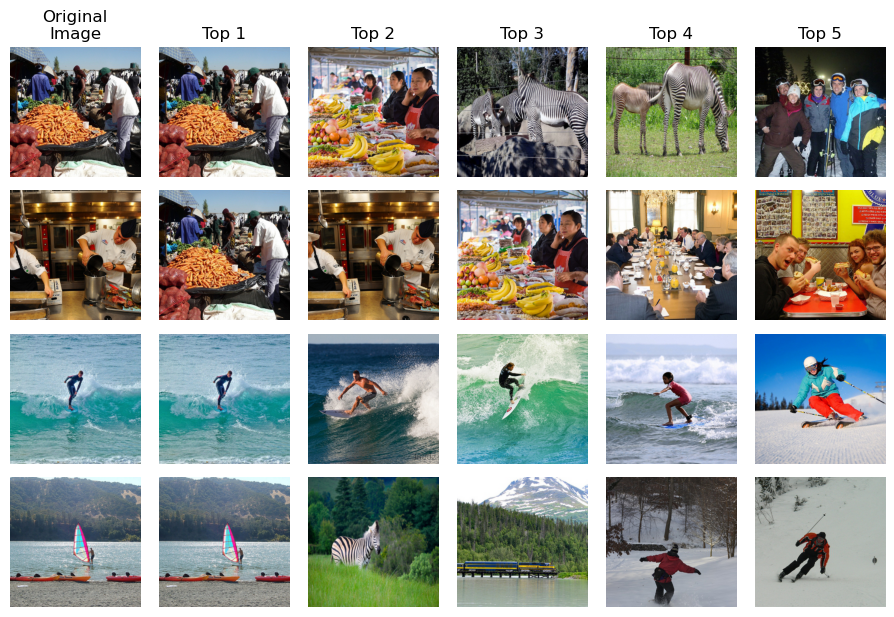

In [21]:
print("Given Brain embedding, find correct Image embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11, 7))  # Adjusted for an additional row for captions
ax[0, 0].set_title("Original\nImage")
for attempt in range(5):
    ax[0, attempt + 1].set_title(f"Top {attempt + 1}")

# Plot images and similarity scores
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt + 1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt + 1].axis("off")

# Adjust layout for tighter fit
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

plt.show()

### Zebra example / Retrieval with batch size 982

In [ ]:
device = 'cpu' # move to cpu to not OOM with all 982 samples
clip_extractor0 = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)
diffusion_prior=diffusion_prior.to(device)

val_data = wds.WebDataset(val_url, resampled=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(982, partial=True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)
for val_i, (voxel, img_input, coco) in enumerate(tqdm(val_dl,total=1)):
    with torch.no_grad():
        voxel = torch.mean(voxel,axis=1).to(device) # average across repetitions

        emb = clip_extractor0.embed_image(img_input.to(device)).float() # CLIP-Image
        
        _, emb_ = diffusion_prior.voxel2clip(voxel.float()) # CLIP-Brain
        
        # flatten if necessary
        emb = emb.reshape(len(emb),-1)
        emb_ = emb_.reshape(len(emb_),-1)
        
        # l2norm 
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        
        labels = torch.arange(len(emb)).to(device)
        bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
        fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip
        
        cnt=len(fwd_sim)
        percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
        percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            
print(percent_correct_fwd, percent_correct_bwd)
fwd_sim = fwd_sim.numpy()
bwd_sim = bwd_sim.numpy()

In [ ]:
zebra_indices = [891, 892, 893, 863, 833, 652, 516, 512, 498, 451, 331, 192, 129, 66]
print("# zebras =", len(zebra_indices))
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(11,5))
for trial,t in enumerate(zebra_indices[:2]):
    ax[trial, 0].imshow(utils.torch_to_Image(img_input[t]))
    ax[trial, 0].set_title("Original image")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[t]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img_input[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

## Brain retrieval visualization

In [ ]:
print("Given Image embedding, find correct Brain embedding")
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()